In [53]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve , generate_binary_structure

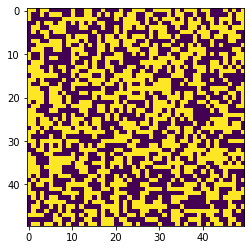

In [54]:
def create_configuration(N):
    init_state = 2*np.random.randint(0,2, size=(N,N))-1
    
    return init_state

initial_state = create_configuration(50)
plt.imshow(initial_state) 

In [55]:
def total_energy(lattice):
    kernel = generate_binary_structure(2,1)
    kernel[1][1] = False
    arr = -lattice*convolve(lattice, kernel, mode='constant', cval=0)
    return arr.sum()

total_energy(initial_state)

48